### **Importing  the Librairies**

In [ ]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly-gpu-2.0-preview
!pip install tf-hub-nightly
!pip install tensorflow==2.0.0-alpha

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.10.0'


ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu-2.0-preview
     |████████████████████████████████| 109 kB 4.3 MB/s 
ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha
     |████████████████████████████████| 107 kB 4.1 MB/s 
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


### Load the data




In [ ]:
from google.colab import drive
drive.mount("/content/drive")

### Prepare training and validation  dataset


In [ ]:
data_dir = "/content/drive/My Drive/Rice_diesease_05.05.22/ricedata_mixed/rice"#os.path.join(os.path.dirname(zip_file), '/content/rice')
train_dir = "/content/drive/My Drive/Rice_diesease_05.05.22/ricedata_mixed/rice/train"#os.path.join(data_dir, 'train')
validation_dir = "/content/drive/My Drive/Rice_diesease_05.05.22/ricedata_mixed/rice/validation"#os.path.join(data_dir, 'validation')



In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /content/drive/My Drive/Rice_diesease_05.05.22/ricedata_mixed/rice/train : 1372files
total images for validation : /content/drive/My Drive/Rice_diesease_05.05.22/ricedata_mixed/rice/validation : 108files


### Label mapping


In [ ]:
!!wget https://github.com/AveyBD/rice-leaf-diseases-detection/archive/master.zip
!unzip master.zip;

Archive:  master.zip
e56f0a072757582b0c8e6db762a720860b8da342
   creating: rice-leaf-diseases-detection-master/
  inflating: rice-leaf-diseases-detection-master/README.md  
  inflating: rice-leaf-diseases-detection-master/Rice_Leaf_Detection.ipynb  
  inflating: rice-leaf-diseases-detection-master/Rice_Leaf_Detection_Colab.ipynb  
  inflating: rice-leaf-diseases-detection-master/classes.json  
  inflating: rice-leaf-diseases-detection-master/rice-leaf.zip  


In [ ]:
import json

with open('rice-leaf-diseases-detection-master/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
classes.append('tungro')
print (classes)

['Bacterial_leaf_blight', 'blast', 'brownspot', 'tungro']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 4




```
# This is formatted as code
```

###Select the Hub/TF2 module to use

In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


### Data Preprocessing




In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 108 images belonging to 4 classes.
Found 1372 images belonging to 4 classes.


###Build the model


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




In [ ]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-10:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 22,853,924
Trainable params: 1,051,140
Non-trainable params: 21,802,784
_______________

### Specify Loss Function and Optimizer

In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

### Train Model


In [ ]:

EPOCHS=45 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/45
21/21 [==============================] - 752s 35s/step - loss: 1.3484 - accuracy: 0.4969 - val_loss: 1.8054 - val_accuracy: 0.1562
Epoch 2/45
21/21 [==============================] - 57s 3s/step - loss: 0.6875 - accuracy: 0.7286 - val_loss: 2.0501 - val_accuracy: 0.1406
Epoch 3/45
21/21 [==============================] - 56s 3s/step - loss: 0.5546 - accuracy: 0.7775 - val_loss: 2.3913 - val_accuracy: 0.1875
Epoch 4/45
21/21 [==============================] - 55s 3s/step - loss: 0.4654 - accuracy: 0.8211 - val_loss: 2.9160 - val_accuracy: 0.1562
Epoch 5/45
21/21 [==============================] - 55s 3s/step - loss: 0.4162 - accuracy: 0.8295 - val_loss: 3.2823 - val_accuracy: 0.0938
Epoch 6/45
21/21 [==============================] - 56s 3s/step - loss: 0.4122 - accuracy: 0.8333 - val_loss: 3.1207 - val_accuracy: 0.1562
Epoch 7/45
21/21 [==============================] - 55s 3s/step - loss: 0.3810 - accuracy: 0.8349 - val_loss: 3.3727 - val_accuracy: 0.1250
Epoch 8/45
21/21 [

###Check Performance


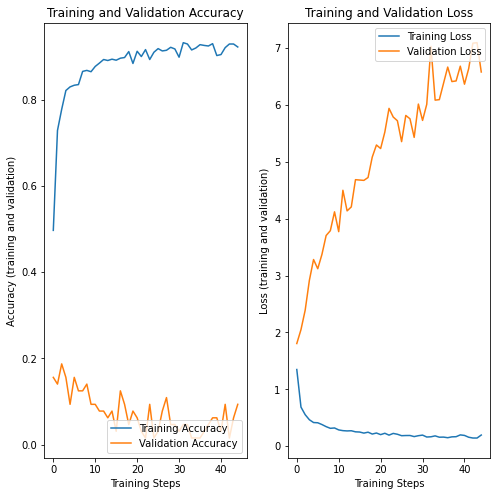

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()    

In [ ]:
import tensorflow_hub as hub
model.save("model_inceptionnet_5may_v1.h5")

### Random test


In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
import os
path =r"/content/drive/My Drive/images_split/images_split/test/Tungro"
list_of_files = []

for root, dirs, files in os.walk(path):
	for file in files:
		list_of_files.append(os.path.join(root,file))
class_name_index = {'Bacterial_leaf_blight':0, 'blast':1, 'brownspot':2, 'tungro':3}
class_count = []
for idx, filename in enumerate(list_of_files):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    class_count.append(class_name_index[list(prediction.keys())[0]])
    #plt.imshow(img)
    #plt.figure(idx)    
    #plt.show()

In [ ]:
flag = 0
for i in range(len(class_count)):
  if(class_count[i] == 3):
    flag +=1

In [ ]:
flag/len(list_of_files)

0.8376623376623377

In [ ]:
filename = "/content/t3.jpg"
img = load_image(filename)
prediction = predict(img)
print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))

PREDICTED: class: tungro, confidence: 0.984716


In [ ]:
def predict(image,new_model):
    probabilities = new_model.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [ ]:
import os
path =r"/content/drive/My Drive/images_split/images_split/test/Blast"
list_of_files = []

for root, dirs, files in os.walk(path):
	for file in files:
		list_of_files.append(os.path.join(root,file))
class_name_index = {'Bacterial_leaf_blight':0, 'blast':1, 'brownspot':2, 'tungro':3}
class_count = []
for idx, filename in enumerate(list_of_files):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img,new_model)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    class_count.append(class_name_index[list(prediction.keys())[0]])
    #plt.imshow(img)
    #plt.figure(idx)    
    #plt.show()

In [ ]:
flag = 0
for i in range(len(class_count)):
  if(class_count[i] == 1):
    flag +=1

In [ ]:
flag/len(list_of_files)

0.7115384615384616